This file is to try Nexis-SBI

Note that, the original Nexis params are bounded, so I transform them first (to real line). 

The simulator fn in our case requires trans-params not the org params. 
I put a guassian prior on the trans-params. 
So the SBI gives the posterior sps of the trans-params, I transform them back to the original params.



### import and define

In [1]:
# code for getting things to run on wynton 
# on the terminal to access wyton so that I can run jupyter notebook
# ssh -J wren@log1.wynton.ucsf.edu -L 8888:localhost:8888 wren@dev1
# this is for sachin, which doesn't have enough computation power to run the model
# ssh -L 9999:localhost:8888 wren@sachin.radiology.ucsf.edu

# the singularity file from justin
# singularity shell sgm_mnec_fc.sif

# once singularity is running
# jupyter notebook

# paste into browser
# change this to what ever the terminal gives you to put in the browser
# http://localhost:9999/?token=a240d5531ae3a931281ff6db2a87a3d8e791f3f08400b8bf

In [2]:
import sys
sys.path.append("../mypkg")
import mkl

# other pkgs
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from torch.distributions.multivariate_normal import MultivariateNormal

import numpy as np
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from functools import partial

import warnings
warnings.filterwarnings("ignore")

# my own pkgs
import importlib

from utils.misc import save_pkl_dict2folder, load_pkl_folder2dict
from utils.reparam import para_trans2org, logistic_np, logistic_torch
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
import from_justin.nexis as nx

In [3]:
# ask about this - i think this is just another experiment...KaufmanDiamond_datasets_dat&seed.mat

# # load the data and build the nexis model
# loadinst = nx.loading_matfiles()
# endm = loadinst.load_file('eNDM_mousedata.mat')
# # the following are required for build a model
# C = endm['Networks'][0,0]['ret']
# C = C / np.max(C[:])
# endm_kauf = loadinst.load_file('KaufmanDiamond_datasets_dat&seed.mat')
# seedvec = endm_kauf['seed426'][0,0]['DS6']
# tpts = endm_kauf['tpts'][0,0]['DS6'][0]
# U = np.zeros([426,1]);

# # the model for generate
# nexis_model = nx.run_Nexis(C, U, seedvec, tpts)

# # real data, the real data decide the nan positions and decide the simulator function
# data = endm_kauf['data426'][0,0]['DS6'];

# np.shape(seedvec)

### Load data 

In [4]:
# in directory from notebook
nx.loading_matfiles

from_justin.nexis.loading_matfiles

In [5]:
# load the data and build the nexis model
loadinst = nx.loading_matfiles()

# load the connectome from the mat file 
# dict_keys(['__header__', '__version__', '__globals__', 'Connectomes']) 
load_connectome = loadinst.load_file('Connectomes.mat')

# load the connectome and access it from the mat format
# default is a subdictionary in connectomes
# shape is (426, 426) for the different regions of the brain connectome
connectome = load_connectome['Connectomes'][0,0]['default']

# normalize by dividing the connectome by the max value of the connectome
connectome = connectome / np.max(connectome[:])

# load the tau data
# dict_keys(['__header__', '__version__', '__globals__', 'mousedata_struct_ccf']) 
# nested dictionaries
# shape is the 426 brain regions and the time points 4,8,12 by weeks
endm = loadinst.load_file('Mouse_Tauopathy_Data_HigherQ_CCF.mat')

# select out the seperate experiments from the tau mat file
# may need some restructing for other experiments - they have different seed vectors
def load_data(endm,label):
    '''
    function for selecting out the data values from the mat file
    '''
    endm_data = endm['mousedata_struct_ccf'][0,0][label][0]['data'][0]
    endm_data = endm_data/np.nansum(endm_data[:,0])
    return endm_data
 
# the different data sets seperated
data_DS4 = load_data(endm,'DS4') # DS4 is human tau
data_DS6 = load_data(endm,'DS6') # DS6 is mouse tau
data_DS7 = load_data(endm,'DS7') # DS7 is synthetic tau
data_DS9 = load_data(endm,'DS9') # DS9 is synthetic tau
data_DS6_110 = load_data(endm,'DS6_110') # same species DS6 injection one tenth - spread pattern looks different
data_DS9_110 = load_data(endm,'DS9_110') # same species DS9 injection one tenth - spread pattern looks different

# just for testing that everything works
data = data_DS4

# the location of mean seeding injection site using ccf common coordinate framework
# this may need to be changed depending on which experiment you are using
seedvec = endm['mousedata_struct_ccf'][0,0]['DS4'][0]['seed'][0]

# time points from the mat file
# 4,8,12 weeks
tpts = endm['mousedata_struct_ccf'][0,0]['DS4'][0]['time_stamps'][0]
tpts = np.ndarray.flatten(tpts)

# empty vector that will be filled with genes, but could be filled with other things like cell type
U = np.zeros([426,1]); 


In [6]:
# need to read in file AGEA_coronal_atlas_regiononly.mat from Justin
# path to the file, mine is on wynton
# dict_keys(['__header__', '__version__', '__globals__', 'AGEA_coronal_atlas_regiononly']) 
gene_file = loadinst.load_file('/wynton/home/rajlab/wren/Nexis_SBI/data/raw_data_mouse/AGEA_coronal_atlas_regiononly.mat')

# get out the data from the mat file
# [0][0][0][0] is the array of gene names, shape 1 vector of gene name, for specific instance 0 for last 0
# [0][0][1][0] is the array of gene values, shape 4083, vector of the gene values, for specific instance 0 for last 0
# [0][0][2][0] is the array of brain regions, shape 4, annotating 4 different aspects of brain region, for specific instance 0 for last 0
gene_values = gene_file['AGEA_coronal_atlas_regiononly']


In [1]:
# get the list of gene names
# 4083 genes in the list x 426 brain regions
gene_name_list = gene_values[0][0][0].ravel()

# the name of the gene i want to look at
# may want to look at the top 10 correlated and top 10 anti-correlated
# from below
gene_string_name = 'Trem2'

# flatten out the array of arrays into just a list for easier regex
# going to use this to search for the gene index to get the appropriate gene values
gene_name_list_stripped = []
for i in  gene_name_list:
    for j in i:
        gene_name_list_stripped.append(j)

# search for the gene without worrying about whether or not its upper or lower case
# prints true if the gene name is present
print(gene_string_name.upper() in (name.upper() for name in gene_name_list_stripped))

# get the index of the gene in the list of gene names
# need to use the proper capitalization for this one so once you see that the above 
# code runs as true, try out a couple different types of capitilzation
# for the gene names the first letter is capitalized and then they are lower case
gene_index_location = gene_name_list_stripped.index(gene_string_name)

NameError: name 'gene_values' is not defined

In [163]:
# index with which to select the gene i want to look at 
gene_index = gene_index_location # string match for trem2

# select the gene name by index
gene_name = gene_name_list[gene_index]

# get the values for the brain regions for the gene selected
gene_index_values = gene_values[0][0][1][:,gene_index]

# min/max normalization
# (Uraw- min(Uraw))/(max(Uraw)-min(Uraw))
# may need to remove the nan regions before doing the min value
# gene_index_values_normalized = (gene_index_values- min(gene_index_values))/(max(gene_index_values)-min(gene_index_values))
# the above runs into some sort of problem down the line in the code, but is the exact same vector
# as the one below...which also runs into the same problem
gene_index_values_normalized = gene_index_values/max(gene_index_values)

# format the gene vector into a way that the model will accept 
# should instead be gene_index_values_normalized, but the normalization ends up making an error
# when drawing the 1k posterior samples
# currently working on this
formated_gene_values = [[item] for item in gene_index_values] # should be gene_index_values_normalized instead


In [164]:
# working on the statistic that Justin wants for tau and gene expression correlation coeff 
# in order to get the top and bottom correlated and anticorrelated genes
def tau_vs_expression_statistic(dataset,label):
    '''
    get the correlation coeff for each dataset against all the gene expressions
    '''
    # get the non nan third column - last time point of the original data
    nonnan_idxs = np.isnan(dataset).sum(axis=1)==0
    original_data = dataset[nonnan_idxs]
    timepoint_three_data = original_data[:,2]

    # correlation for trem2 or which ever gene you use for the gene vector
    print('correlation coef for {0} {1}'.format(gene_name,label),np.corrcoef(timepoint_three_data,gene_index_values_normalized[nonnan_idxs])[0,1])
    
    # reshape the gene values for easier access
    extract_gene_values = gene_values[0][0][1].T
    
    # collect the results 
    collect_correlation_coeff = []
    # for each gene 
    # np.corrcoef( should be able to handle a matrix....fix?
    for g in extract_gene_values:
        # get the non nan for the gene expression
        original_formated_gene_values = g[nonnan_idxs]
        # then for each gene (you can even do this in a for loop although it’s not as efficient) 
        # just do corr of each column of gene expression (i.e. each gene) and DS4 tau
        # np.corrcoef() of these two things
        # R value here is a similarity measure between two vectors
        # here, pathology and gene expression across regions    
        corrcoef_tau_expression = np.corrcoef(timepoint_three_data,original_formated_gene_values)
        collect_correlation_coeff.append(corrcoef_tau_expression[0,1])
    return collect_correlation_coeff

# get the correltion coeff for each of the datasets
collect_correlation_coef_ds4 = tau_vs_expression_statistic(data_DS4,'DS4')
collect_correlation_coef_ds6 = tau_vs_expression_statistic(data_DS6,'DS6')
collect_correlation_coef_ds7 = tau_vs_expression_statistic(data_DS7,'DS7')
collect_correlation_coef_ds9 = tau_vs_expression_statistic(data_DS9,'DS9')
collect_correlation_coef_ds6_110 = tau_vs_expression_statistic(data_DS6_110,'DS6_110')
collect_correlation_coef_ds9_110 = tau_vs_expression_statistic(data_DS9_110,'DS9_110')

# average the experiements coeff together over experiements
correltion_coeffs = [collect_correlation_coef_ds4,collect_correlation_coef_ds6,collect_correlation_coef_ds7,
                    collect_correlation_coef_ds9,collect_correlation_coef_ds6_110,collect_correlation_coef_ds9_110]
correltion_coeffs_average = np.average(correltion_coeffs, axis=0)


correlation coef for ['Trem2'] DS4 0.06771774774994613
correlation coef for ['Trem2'] DS6 0.34487183500378793
correlation coef for ['Trem2'] DS7 0.1664868305932874
correlation coef for ['Trem2'] DS9 0.30669374054489495
correlation coef for ['Trem2'] DS6_110 0.2565257847977171
correlation coef for ['Trem2'] DS9_110 0.2565257847977171


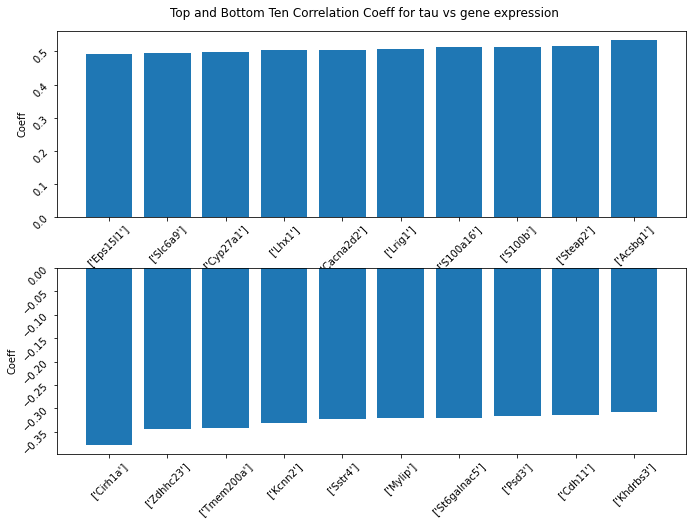

In [165]:

# get the top 10 most correlated and the top 10 most anti-correlated
sorted_index_array = np.argsort(correltion_coeffs_average) 
top_ten = sorted_index_array[0:10]
bottom_ten = sorted_index_array[-10:]

# get the gene names for the top and bottom ten
collect_top_genes = [str(gene_name_list[i]) for i in top_ten]
collect_bottom_genes = [str(gene_name_list[i]) for i in bottom_ten]

# get the correlation coef for the top and bottom ten
collect_top_correlated_coef = [correltion_coeffs_average[i] for i in top_ten]
collect_bottom_correlated_coef = [correltion_coeffs_average[i] for i in bottom_ten]

# plot as bar plots in subplots
fig, axs = plt.subplots(2, figsize=(10,7))
fig.tight_layout(pad=3.0)
fig.suptitle('Top and Bottom Ten Correlation Coeff for tau vs gene expression')
axs[0].bar(collect_top_genes,collect_bottom_correlated_coef)
axs[1].bar(collect_bottom_genes,collect_top_correlated_coef)
axs[0].tick_params(labelrotation=45)
axs[1].tick_params(labelrotation=45)
axs[0].set_ylabel('Coeff')
axs[1].set_ylabel('Coeff')

plt.show()

# what are these genes responsible for?

In [166]:
# the model for generate
# w_dir_ is with directionality, volocorrect is necessary correction factor for keeping mass in system
# volcorrect mass relationship between mass and concentration flow
# formated_gene_values is for the vector with the gene expression
# can also be U for the zero vector
nexis_model = nx.run_Nexis(connectome, formated_gene_values, seedvec, tpts, w_dir_ = 1, volcorrect_ = 1) # Keep same

#### Set up Parameters

In [167]:
# some constant parameters for this file
# typically not change
paras_ = edict()
paras_.n_types = U.shape[1]

# same order to the function
# the lower bounds for the parameters
paras_.par_low = np.array([0, 0, 0, 0, -5, -5]) # Keep same

# the higher bounds for the parameters
# maybe play around with this one, lower paras_.par_high[1] to 3 and lower paras_.par_high[2] to 5(?)
# what would be the benefit of changing these params? is this something I should do, or just an option?
paras_.par_high = np.array([1, 10, 2, 1, 5, 5]) 
paras_.bds = np.array([paras_.par_low, paras_.par_high]).T

# alpha is gene independent accumulation
# beta is gene independent spread
# gamma is scaling between seed and data
# s is directionality
# b is gene dependent modulation of transition
# p is gene dependent modulation of accumulation
# the parameter for var transfomration
# take the length of b and p into account
paras_.names = ["alpha", "beta", "gamma", "s", "b", "p"]

paras_.bds_full = np.concatenate([paras_.bds[:-2], 
    np.repeat(paras_.bds[-2].reshape(1, -1), paras_.n_types, axis=0),
    np.repeat(paras_.bds[-1].reshape(1, -1), paras_.n_types, axis=0),
    ])

# tied to _para_trans2org, 
paras_.k = 0.1 # Keep same 

# convert the trans-param back to the org params
# what is this
# sbi to work needs continuous distribution
# transforms uniform bounded to unbounded continuous
_para_trans2org = partial(para_trans2org,map_fn=partial(logistic_np, k=paras_.k))

# print(paras)
# Some hyperparams, tuning them for better results
paras = edict()

# the std of noise added to the simulated data, now my formula is simu_data * (1+noise)
# You may want to tune it. Larger one, smoother of the posterior.
# adding noise to the model outputs that is training on
paras.noise_sd = 1.75 # for Lucia: CHANGE THIS ONE: range [0,2] (maybe linear from 0 to 2, 0.2 step size)
# The num of simulated sps used for training the model, 1e3 is too small, make it larger. 

# The larger, the better, but you also have to consider the computational burden.
paras.num_prior_sps = int(100000) # CHANGE THIS ONE: range [1e4,2e5] (pick a few: 10000,50000,100000,200000)

# The density estimator. 
# Without solid reason, do not change it 
paras.den_est = "nsf" # Keep same

# The std of prior of the parameters
# Without solid reason, do not change it 
# If you change it, you have to also adjust paras_.k
paras.prior_sd = 10 # Keep same

In [168]:
# save the results
# may need to add a time signature in order not to overwrite previously saved results
_folder_path = f"./nexis_num{paras.num_prior_sps:.0f}" +\
               f"_sd{paras.noise_sd*100:.0f}" +\
               f"_betaub{paras_.par_high[1]}" +\
               f"_gammaub{paras_.par_high[2]}"
paras.folder_path = RES_ROOT/_folder_path
print(f"folder is {paras.folder_path}")
if not paras.folder_path.exists():
    paras.folder_path.mkdir()

folder is /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2


### Prepare for SBI

In [169]:
# The main fn in SBI, simulate the data

### super importanattttt!
# data is set to data_DS4

def simulator(para_trans, noise_sd):
    """I add noise by multiplying"""
    para_org = _para_trans2org(para_trans, paras_.bds_full)
    
    # make model based on model params
    res = nexis_model.simulate_nexis(para_org)
    
    # remove the part of simu-data corresponding to the nan in the real data
    nonnan_idxs = ~np.isnan(data.sum(axis=1))
    res = res[nonnan_idxs]
    
    # res is prediction, plus noise noisea_sd is controlling noise distribution width
    noise = np.random.randn(*res.shape)*noise_sd + 1
    return res * noise

In [170]:
# The prior dist to generate the simulated data
# create the distribution for the transform params multivariable normal distribution
prior = MultivariateNormal(loc=torch.zeros(paras_.bds_full.shape[0]), 
                           covariance_matrix=torch.eye(paras_.bds_full.shape[0])*(paras.prior_sd**2))

### SBI

In [171]:
simulator_sp = partial(simulator,  noise_sd=paras.noise_sd)
# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator_sp, prior)


#### RUN

In [172]:
# generate the simulated sps
params, x = simulate_for_sbi(simulator_wrapper, prior, 
                            num_simulations=int(paras.num_prior_sps), 
                            num_workers=10); # Don't change


Running 100000 simulations in 100000 batches.:   0%|          | 0/100000 [00:00<?, ?it/s]

/wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/utils/reparam.py:32: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  res[np.isinf(num)] = 1
/wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/utils/reparam.py:32: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  res[np.isinf(num)] = 1
/wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/utils/reparam.py:32: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  res[np.isinf(num)] = 1
/wynton

In [173]:
# dummy results for working on sachin
# params_dummy = torch.cat([params,params,params])
# x is the results
# x_dummy = torch.cat([x,x,x])

In [174]:
# training and get the posterior
# go through this
inference = SNPE(prior=prior, density_estimator=paras.den_est)
density_estimator = inference.append_simulations(params, x).train() # here is where i put the dummys before
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 32 epochs.

In [175]:
# save it 
# make sure the saved files are not being over writen
cur_res = edict()
cur_res.params_trans = params
cur_res.x = x
cur_res.posterior = posterior
save_pkl_dict2folder(paras.folder_path, cur_res, is_force=True)


Save to /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/params_trans.pkl
Save to /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/x.pkl
Save to /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/posterior.pkl


### Posterior and scatterplots

In [176]:
#load from saved files
# so i don't have to run everything over again
cur_res = load_pkl_folder2dict(paras.folder_path, ["x", "para*"]);

Load file /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/post_sps_org.pkl
Load file /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/post_sps_trans.pkl
Load file /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/posterior.pkl


In [177]:
def query_posterior_statistics_from_sbi(dataset):
    '''
    takes in the data from DS4-DS9_110
    transforms to remove the nans
    queries and returns the posterior statistics
    '''
    # pre processing to remove nan
    nonnan_idxs = np.isnan(dataset).sum(axis=1)==0
    data_part = dataset[nonnan_idxs];
    cur_x_data = data_part.flatten();
    cur_x_data = torch.Tensor(cur_x_data)
    post_sps_trans_data = cur_res.posterior.sample((1000, ),  x=cur_x_data);
    #cur_res.post_sps_trans_data = post_sps_trans_data
    post_sps_org_data = _para_trans2org(post_sps_trans_data, paras_.bds_full); # 1000 samples forming the posteriors of the parameters in the original space

    # Query posterior statistics
    # the distributions from sbi of the parameters
    param_post_data = np.array(post_sps_org_data) # Convert to numpy array
    postmean_data = np.mean(param_post_data,axis = 0) # Take mean over simulations (or whichever statistic you want, e.g. median, mode)
    return postmean_data

def test_model_fit_using_mean_params(dataset):
    '''
    takes in the data from DS4-DS9_110
    tests the model fit using the mean of the parameters
    predicts based on the params
    returns ...
    '''
    # Test out overall model fit using the mean of the parameters
    # prediction based on parameteres
    y_predictions = nexis_model.simulate_nexis(dataset) # Run the Nexis model using the best estimate of the parameters
    
    # for some reason only works for data rather than the in def dataset
    # so i have to set data to dataset in the for loop
    nonnan_idxs = np.isnan(data).sum(axis=1)==0
    # remove the unsampled regions from both the predictions comeing out of the model and 
    # the original dataset
    y_predictions_part = y_predictions[nonnan_idxs]
    data_part = data[nonnan_idxs]
    
    test = np.shape(y_predictions_part)
    test = test[0]
    y_predictions_part_vec = np.reshape(y_predictions_part,(test*3,1)) # Flatten all time points of model simulation into a vector
    y_predictions_part_vec = np.ndarray.flatten(y_predictions_part_vec)
    data_part_vec = np.reshape(data_part,(test*3,1)) # Flatten all time points of data into a vector
    data_part_vec = np.ndarray.flatten(data_part_vec)

    # get the correlation coef for each time point
    R_all_data = np.corrcoef(y_predictions_part_vec,data_part_vec)# Calculate R
    R_all_data = R_all_data[0,1]
    R_1_data = np.corrcoef(y_predictions_part[:,0],data_part[:,0])# Calculate R
    R_1_data = R_1_data[0,1]
    R_2_data = np.corrcoef(y_predictions_part[:,1],data_part[:,1])# Calculate R
    R_2_data = R_2_data[0,1]
    R_3_data = np.corrcoef(y_predictions_part[:,2],data_part[:,2])# Calculate R
    R_3_data = R_3_data[0,1]
    
    return [R_all_data, R_1_data, R_2_data, R_3_data, y_predictions_part,data_part]

def plot_results_from_model_fit(model_fit_results,label):
    '''
    plots the model fit results and uses the label provided
    '''
    # add labels for data time points
    plt.plot(model_fit_results[4][:,0],model_fit_results[5][:,0],"ro",label='4w') # time one 
    plt.plot(model_fit_results[4][:,1],model_fit_results[5][:,1],"go",label='8w') # time two
    plt.plot(model_fit_results[4][:,2],model_fit_results[5][:,2],"bo",label='12w') # time three
#     plt.title(gene_name)
    plt.legend()
    plt.ylabel("{0} data".format(label))
    plt.xlabel("{0} SBI".format(label))
    plt.show()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

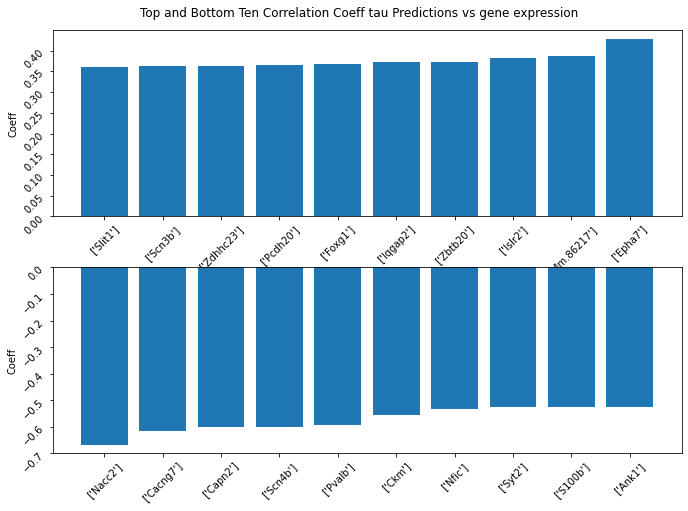

In [178]:
# second statistic that Justin wants
# average correlation to the dataset

# datasets = [data_DS4,data_DS6,data_DS7,data_DS9,data_DS6_110,data_DS9_110]
# labels = ['DS4','DS6','DS7','DS9','DS6_110','DS9_110']

def tau_prediction_vs_expression_statistic(dataset):

    # get the non nan values for the final time point for the predictions
    postmean_data = query_posterior_statistics_from_sbi(dataset)
    y_predictions = nexis_model.simulate_nexis(postmean_data) # Run the Nexis model using the best estimate of the parameters
    nonnan_idxs = np.isnan(dataset).sum(axis=1)==0
    original_predictions = y_predictions[nonnan_idxs]
    timepoint_three_predictions = original_predictions[:,2]

    # get the non nan values for the final time point for the data
    original_data = dataset[nonnan_idxs]
    timepoint_three_data = original_data[:,2]

    residual_timepoint_three = timepoint_three_data - timepoint_three_predictions
    
    extract_gene_values = gene_values[0][0][1].T
    collect_correlation_coeff = []
    for g in extract_gene_values:
        # get the non nan for the gene expression
        original_formated_gene_values = g[nonnan_idxs]
        # then for each gene (you can even do this in a for loop although it’s not as efficient) 
        # just do corr of each column of gene expression (i.e. each gene) and tau predictions
        # np.corrcoef() of these two things
        # R value here is a similarity measure between two vectors
        # here, pathology and gene expression across regions    
        corrcoef_tau_residual_expression = np.corrcoef(residual_timepoint_three,
                                                          original_formated_gene_values)
        collect_correlation_coeff.append(corrcoef_tau_residual_expression[0,1])
    return collect_correlation_coeff 

# get the correlation coef for each dataset
collect_residual_correlation_coeff_ds4 = tau_prediction_vs_expression_statistic(data_DS4)    
collect_residual_correlation_coeff_ds6 = tau_prediction_vs_expression_statistic(data_DS6)    
collect_residual_correlation_coeff_ds7 = tau_prediction_vs_expression_statistic(data_DS7)    
collect_residual_correlation_coeff_ds9 = tau_prediction_vs_expression_statistic(data_DS9)    
collect_residual_correlation_coeff_ds6_110 = tau_prediction_vs_expression_statistic(data_DS6_110)    
collect_residual_correlation_coeff_ds9_110 = tau_prediction_vs_expression_statistic(data_DS9_110)    

# average the experiements coeff together over experiements
residual_correltion_coeffs = [collect_residual_correlation_coeff_ds4,
                     collect_residual_correlation_coeff_ds6,
                     collect_residual_correlation_coeff_ds7,
                     collect_residual_correlation_coeff_ds9,
                     collect_residual_correlation_coeff_ds6_110,
                     collect_residual_correlation_coeff_ds9_110]
residual_correltion_coeffs_average = np.average(residual_correltion_coeffs, axis=0)   

# get the top 10 most correlated and the top 10 most anti-correlated
# add to the names 'residual'
sorted_index_array = np.argsort(residual_correltion_coeffs_average) 
top_ten = sorted_index_array[0:10]
bottom_ten = sorted_index_array[-10:]

# get the gene names for the top and bottom ten
collect_top_genes = [str(gene_name_list[i]) for i in top_ten]
collect_bottom_genes = [str(gene_name_list[i]) for i in bottom_ten]

# get the correlation coef for the top and bottom ten
collect_top_correlated_coef = [residual_correltion_coeffs_average[i] for i in top_ten]
collect_bottom_correlated_coef = [residual_correltion_coeffs_average[i] for i in bottom_ten]

# plot as bar plots in subplots
fig, axs = plt.subplots(2, figsize=(10,7))
fig.tight_layout(pad=3.0)
fig.suptitle('Top and Bottom Ten Correlation Coeff tau Predictions vs gene expression')
axs[0].bar(collect_top_genes,collect_bottom_correlated_coef)
axs[1].bar(collect_bottom_genes,collect_top_correlated_coef)
axs[0].tick_params(labelrotation=45)
axs[1].tick_params(labelrotation=45)
axs[0].set_ylabel('Coeff')
axs[1].set_ylabel('Coeff')

plt.show()


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

alpha=0.197, beta=3.067, gamma=0.39, s=0.518, b=-0.482, p=0.044
R_all_0 = 0.55
R_1_0 = 0.69
R_2_0 = 0.53
R_3_0 = 0.27


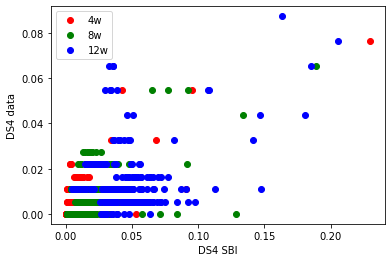

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

alpha=0.237, beta=2.28, gamma=0.442, s=0.503, b=-0.373, p=0.02
R_all_0 = 0.63
R_1_0 = 0.59
R_2_0 = 0.57
R_3_0 = 0.62


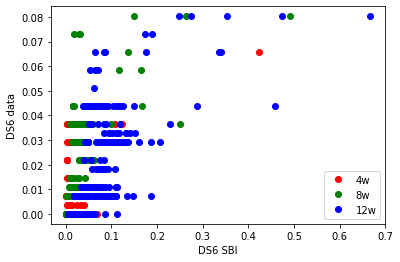

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

alpha=0.252, beta=2.204, gamma=0.35, s=0.453, b=-0.481, p=0.172
R_all_0 = 0.56
R_1_0 = 0.63
R_2_0 = 0.57
R_3_0 = 0.53


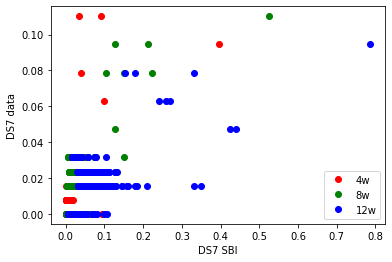

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

alpha=0.187, beta=4.658, gamma=0.375, s=0.513, b=-0.438, p=-0.012
R_all_0 = 0.64
R_1_0 = 0.42
R_2_0 = 0.55
R_3_0 = 0.60


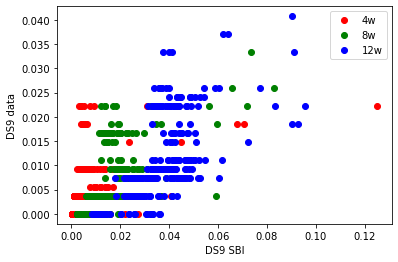

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

alpha=0.213, beta=2.538, gamma=0.455, s=0.674, b=-0.467, p=-0.042
R_all_0 = 0.50
R_1_0 = 0.19
R_2_0 = 0.52
R_3_0 = 0.54


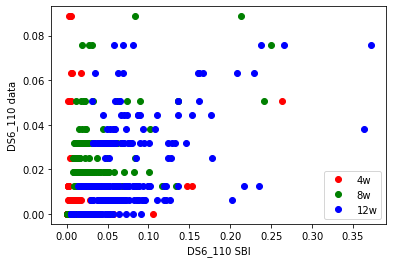

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

alpha=0.302, beta=2.254, gamma=0.326, s=0.54, b=-0.329, p=0.067
R_all_0 = 0.62
R_1_0 = 0.63
R_2_0 = 0.35
R_3_0 = 0.56


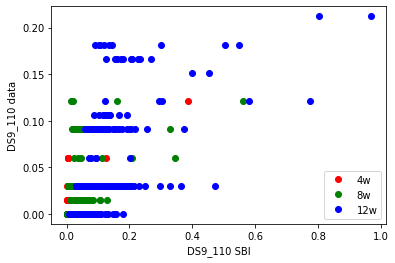

In [180]:
# pair teh data sets with their labels
datasets = [data_DS4,data_DS6,data_DS7,data_DS9,data_DS6_110,data_DS9_110]
labels = ['DS4','DS6','DS7','DS9','DS6_110','DS9_110']

for dataset,label in zip(datasets,labels):
    # set data to dataset because there is a really annoying error if i dont
    data = dataset
    postmean_data = query_posterior_statistics_from_sbi(dataset)
    summary_statistics = test_model_fit_using_mean_params(postmean_data)

    # paras_.names = ["alpha", "beta", "gamma", "s", "b", "p"]
    print('{0}={1}, {2}={3}, {4}={5}, {6}={7}, {8}={9}, {10}={11}'.format(
        paras_.names[0],postmean_data[0].round(3),
        paras_.names[1],postmean_data[1].round(3),
        paras_.names[2],postmean_data[2].round(3),
        paras_.names[3],postmean_data[3].round(3),
        paras_.names[4],postmean_data[4].round(3),
        paras_.names[5],postmean_data[5].round(3),'\n'))
    print(f'R_all_{0} = {summary_statistics[0]:.2f}'.format(label))
    print(f'R_1_{0} = {summary_statistics[1]:.2f}'.format(label))
    print(f'R_2_{0} = {summary_statistics[2]:.2f}'.format(label))
    print(f'R_3_{0} = {summary_statistics[3]:.2f}'.format(label))

    plot_results_from_model_fit(summary_statistics,label)

### Posterior 

In [181]:
# load from pickle
cur_res = load_pkl_folder2dict(paras.folder_path, ["x", "para*"]);

Load file /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/post_sps_org.pkl
Load file /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/post_sps_trans.pkl
Load file /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/posterior.pkl


In [182]:
# just to remove nan
# now my real data has nan, you should find a way to handle the nan
nonnan_idxs = np.isnan(data_DS4).sum(axis=1)==0
data_part = data_DS4[nonnan_idxs];
cur_x = data_part.flatten();
cur_x = torch.Tensor(cur_x)
post_sps_trans = cur_res.posterior.sample((1000, ),  x=cur_x);

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Save to /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/post_sps_org.pkl
Save to /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/post_sps_trans.pkl
Save to /wynton/home/rajlab/wren/Nexis_SBI/notebooks/../mypkg/../results/nexis_num100000_sd175_betaub10_gammaub2/posterior.pkl


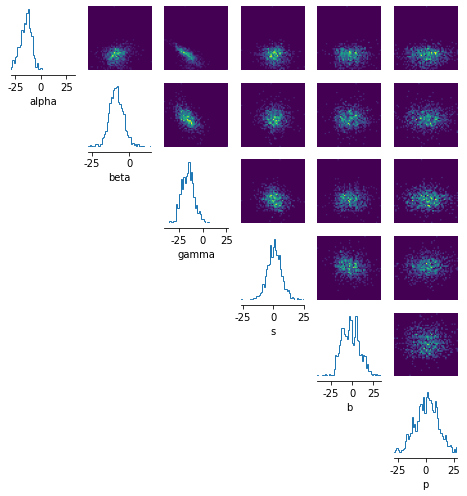

In [183]:
cur_res.post_sps_trans = post_sps_trans
save_pkl_dict2folder(paras.folder_path, cur_res, is_force=True, verbose=True);
_ = analysis.pairplot(cur_res.post_sps_trans,
                      labels=paras_.names, 
                      figsize=(8,8));

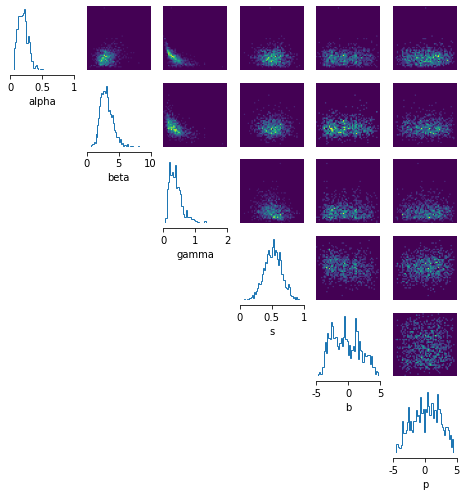

In [184]:
# from trans_data to org data
post_sps_org = _para_trans2org(cur_res.post_sps_trans, paras_.bds_full); # 1000 samples forming the posteriors of the parameters in the original space
cur_res.post_sps_org = post_sps_org
save_pkl_dict2folder(paras.folder_path, cur_res, is_force=True, verbose=False)
_ = analysis.pairplot(cur_res.post_sps_org,
                      limits=paras_.bds_full,
                      labels=paras_.names, 
                      figsize=(8,8));

In [185]:
# Create model from modes of distributions and compare (e.g. Pearson's correlation, scatterplot) with the data

In [186]:
# Tablulate the correspondence between model and data as a function of the parameters that were used
# and the hyperparameters/conditions that were passed to SBI to compare/contrast and find an "optimal"
# way to run

In [187]:
# Query posterior statistics
param_post = np.array(post_sps_org) # Convert to numpy array
postmean = np.mean(param_post,axis = 0) # Take mean over simulations (or whichever statistic you want, e.g. median, mode)
print(postmean)

[ 0.19633021  3.04136722  0.38471485  0.51399634 -0.4447774   0.20835576]


In [188]:
# Test out overall model fit using the mean of the parameters
y = nexis_model.simulate_nexis(postmean) # Run the Nexis model using the best estimate of the parameters
y_part = y[nonnan_idxs] # remove unsampled regions
test = np.shape(y_part)
test = test[0]
y_part_vec = np.reshape(y_part,(test*3,1)) # Flatten all time points of model simulation into a vector
y_part_vec = np.ndarray.flatten(y_part_vec)
data_part_vec = np.reshape(data_part,(test*3,1)) # Flatten all time points of data into a vector
data_part_vec = np.ndarray.flatten(data_part_vec)
print(np.corrcoef(y_part_vec,data_part_vec)) # Calculate R
print(np.corrcoef(y_part[:,0],data_part[:,0]))
print(np.corrcoef(y_part[:,1],data_part[:,1]))
print(np.corrcoef(y_part[:,2],data_part[:,2]))

[[1.         0.55475676]
 [0.55475676 1.        ]]
[[1.         0.68708882]
 [0.68708882 1.        ]]
[[1.         0.52851343]
 [0.52851343 1.        ]]
[[1.         0.27109809]
 [0.27109809 1.        ]]


In [189]:
# Lucia list of things
# Summary of things to test:
# Prior noise term (bounded between 0 and 2)
# Number of samples to train SBI on (bounded between 1e4 and 2e5)

# Desired outputs (tabular)
# Posterior statistics (mean, median, standard deviation) on the four relevant model parameters
# Fits to data per time point (R or R^2)
# Overall fit to data across time point (R or R^2)
# Scatterplots of best hyperparameter sets

In [190]:
# top/bottom 200 for gene ontology
# https://github.com/tanghaibao/goatools
# https://www.youtube.com/watch?v=ONiWugVEf2s&ab_channel=Sanbomics

!pip install goatools

# https://www.ncbi.nlm.nih.gov/gene
# paste below code into search
# "10090"[Taxonomy ID] AND alive[property] AND genetype protein coding[Properties]
# 10090 is mouse 9606



# the gene indeces for the original data
sorted_index_array = np.argsort(correltion_coeffs_average)
top_twohundred = sorted_index_array[0:200]
bottom_twohundred = sorted_index_array[-200:]

# get the gene names for the top and bottom ten
collect_top_genes = [str(gene_name_list[i]) for i in top_twohundred]
collect_bottom_genes = [str(gene_name_list[i]) for i in bottom_twohundred]


# # the gene indeces for the predictions
# sorted_index_array = np.argsort(residual_correltion_coeffs_average) 
# top_twohundred_predicted = sorted_index_array[0:200]
# bottom_twohundred_predicted = sorted_index_array[-200:]

# # get the gene names for the top and bottom ten
# collect_predicted_top_genes = [str(gene_name_list[i]) for i in top_twohundred_predicted]
# collect_predicted_bottom_genes = [str(gene_name_list[i]) for i in bottom_twohundred_predicted]



Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 15.8 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 240 kB 116.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 103.5 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 476 kB/s s eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13724 sha256=fb820c690a578d1bdb4468dc6253038c4b204d203e8960eef38a582104de2a39
  Stored in directory: /wynton/home/rajlab/wren/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.